
# TP Final — Predicción de Precios de Viviendas

**Fecha:** 2025-11-04  
**Equipo:**   
**Objetivo de negocio:** Estimar el precio de venta de una vivienda para **tasar correctamente**, **acelerar la venta** y **mejorar la rentabilidad** de inmobiliarias y bancos.

---

## Guía de lectura 
- **Secciones 1–3:** Carga y *AutoEDA*.
- **Sección 4:** Limpieza y *feature engineering*.
- **Sección 5:** Modelos base y comparación con métricas de negocio.
- **Sección 6:** *Insights* y recomendaciones.

## 1) Configuración e imports

In [1]:
import sys
import subprocess
import importlib
import os
import json
import zipfile
import pathlib
import pandas as pd
import numpy as np


# Modelado
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


if sys.version_info >= (3,13):
    raise RuntimeError(
        f"Este notebook necesita Python <= 3.12 para usar PyCaret. "
        f"Estás en {sys.version.split()[0]}. Cambiá el kernel a Python 3.11/3.12."
    )

def ensure(pkg):
    if importlib.util.find_spec(pkg) is None:
        print(f"📦 Instalando {pkg} en {sys.executable} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "pip", "setuptools", "wheel"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
    else:
        print(f"✅ {pkg} ya está instalado.")

for dep in ["kaggle", "pycaret"]:
    ensure(dep)

######################################################################################################################
# CONECTAR CON KAGGLE
######################################################################################################################

from kaggle.api.kaggle_api_extended import KaggleApi

# Validar token
home = pathlib.Path.home()
kaggle_dir = home / ".kaggle"
kaggle_json = kaggle_dir / "kaggle.json"
if not kaggle_json.exists():
    raise RuntimeError(
        f"Error con el archivo .JSON"
    )

# Autenticación
os.environ["KAGGLE_CONFIG_DIR"] = str(kaggle_dir)
api = KaggleApi()
api.authenticate()

# Competencia
COMP = "house-prices-advanced-regression-techniques"


# Chequear listar archivos (test de permisos)
resp = api.competition_list_files(COMP)

# Normalizar a lista de items
items = getattr(resp, "files", resp)

# Obtener nombres
names = []
for f in items:
    name = getattr(f, "name", None)
    if not name:
        name = getattr(f, "fileName", None)
    if not name:
        name = str(f)
    names.append(name)

print("Archivos disponibles en la competencia:", names)

# Descargar a data/kaggle
dest = pathlib.Path("data/kaggle")
dest.mkdir(parents=True, exist_ok=True)
api.competition_download_files(COMP, path=str(dest), force=True, quiet=False)

# Descomprimir cualquier ZIP
for z in dest.glob("*.zip"):
    print(f"Descomprimiendo {z.name}...")
    with zipfile.ZipFile(z, "r") as zip_ref:
        zip_ref.extractall(dest)

print(f"✅ Listo. Archivos en: {dest.resolve()}")

print("✅ Entorno listo.")


📦 Instalando kaggle en c:\Users\lesanmartin\Desktop\Trabajo Final Aprendizaje Automatico\Aprendizaje_Automatico\.venv-pycaret\Scripts\python.exe ...
✅ pycaret ya está instalado.
Archivos disponibles en la competencia: ['data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']


100%|██████████| 199k/199k [00:00<00:00, 17.1MB/s]


Descomprimiendo house-prices-advanced-regression-techniques.zip...
✅ Listo. Archivos en: C:\Users\lesanmartin\Desktop\Trabajo Final Aprendizaje Automatico\Aprendizaje_Automatico\data\kaggle
✅ Entorno listo.


| **Atributo**   | **Descripción (en español)**                                       | **Opciones posibles**                                                                                                                                                                                                                                                                                                                                                                                                      |
| -------------- | ------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `MSSubClass`   | Identifica el tipo de vivienda involucrada en la venta.            | 20: 1-STORY 1946 & NEWER ALL STYLES; 30: 1-STORY 1945 & OLDER; 40: 1-STORY W/FINISHED ATTIC ALL AGES; 45: 1-1/2 STORY UNFINISHED ALL AGES; 50: 1-1/2 STORY FINISHED ALL AGES; 60: 2-STORY 1946 & NEWER; 70: 2-STORY 1945 & OLDER; 75: 2-1/2 STORY ALL AGES; 80: SPLIT OR MULTI-LEVEL; 85: SPLIT FOYER; 90: DUPLEX; 120: 1-STORY PUD; 150: 1-1/2 STORY PUD; 160: 2-STORY PUD; 180: PUD MULTILEVEL; 190: 2 FAMILY CONVERSION |
| `MSZoning`     | Clasificación general de zonificación del terreno.                 | A, C, FV, I, RH, RL, RP, RM                                                                                                                                                                                                                                                                                                                                                                                                |
| `LotFrontage`  | Pies lineales de calle conectados a la propiedad.                  | —                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `LotArea`      | Tamaño del terreno en pies cuadrados.                              | —                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `Street`       | Tipo de acceso vial.                                               | Grvl, Pave                                                                                                                                                                                                                                                                                                                                                                                                                 |
| `Alley`        | Tipo de acceso por callejón.                                       | Grvl, Pave, NA                                                                                                                                                                                                                                                                                                                                                                                                             |
| `LotShape`     | Forma del terreno.                                                 | Reg, IR1, IR2, IR3                                                                                                                                                                                                                                                                                                                                                                                                         |
| `LandContour`  | Relieve o nivel del terreno.                                       | Lvl, Bnk, HLS, Low                                                                                                                                                                                                                                                                                                                                                                                                         |
| `Utilities`    | Tipo de servicios disponibles.                                     | AllPub, NoSewr, NoSeWa, ELO                                                                                                                                                                                                                                                                                                                                                                                                |
| `LotConfig`    | Configuración del terreno.                                         | Inside, Corner, CulDSac, FR2, FR3                                                                                                                                                                                                                                                                                                                                                                                          |
| `LandSlope`    | Pendiente del terreno.                                             | Gtl, Mod, Sev                                                                                                                                                                                                                                                                                                                                                                                                              |
| `Neighborhood` | Vecindario dentro de los límites de Ames.                          | Blmngtn, Blueste, BrDale, BrkSide, ClearCr, CollgCr, Crawfor, Edwards, Gilbert, IDOTRR, MeadowV, Mitchel, Names, NoRidge, NPkVill, NridgHt, NWAmes, OldTown, SWISU, Sawyer, SawyerW, Somerst, StoneBr, Timber, Veenker                                                                                                                                                                                                     |
| `Condition1`   | Proximidad a diversas condiciones.                                 | Artery, Feedr, Norm, RRNn, RRAn, PosN, PosA, RRNe, RRAe                                                                                                                                                                                                                                                                                                                                                                    |
| `Condition2`   | Segunda condición de proximidad (si aplica).                       | Artery, Feedr, Norm, RRNn, RRAn, PosN, PosA, RRNe, RRAe                                                                                                                                                                                                                                                                                                                                                                    |
| `BldgType`     | Tipo de vivienda.                                                  | 1Fam, 2FmCon, Duplx, TwnhsE, TwnhsI                                                                                                                                                                                                                                                                                                                                                                                        |
| `HouseStyle`   | Estilo o cantidad de pisos.                                        | 1Story, 1.5Fin, 1.5Unf, 2Story, 2.5Fin, 2.5Unf, SFoyer, SLvl                                                                                                                                                                                                                                                                                                                                                               |
| `OverallQual`  | Calidad general de materiales y terminaciones.                     | 1 a 10 (Very Poor → Very Excellent)                                                                                                                                                                                                                                                                                                                                                                                        |
| `OverallCond`  | Condición general de la vivienda.                                  | 1 a 10 (Very Poor → Very Excellent)                                                                                                                                                                                                                                                                                                                                                                                        |
| `YearBuilt`    | Año de construcción original.                                      | —                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `YearRemodAdd` | Año de remodelación (igual al de construcción si no hubo cambios). | —                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `RoofStyle`    | Tipo de techo.                                                     | Flat, Gable, Gambrel, Hip, Mansard, Shed                                                                                                                                                                                                                                                                                                                                                                                   |
| `RoofMatl`     | Material del techo.                                                | ClyTile, CompShg, Membran, Metal, Roll, Tar&Grv, WdShake, WdShngl                                                                                                                                                                                                                                                                                                                                                          |
| `Exterior1st`  | Revestimiento exterior principal.                                  | AsbShng, AsphShn, BrkComm, BrkFace, CBlock, CemntBd, HdBoard, ImStucc, MetalSd, Other, Plywood, PreCast, Stone, Stucco, VinylSd, Wd Sdng, WdShing                                                                                                                                                                                                                                                                          |
| `Exterior2nd`  | Revestimiento exterior secundario.                                 | Igual a `Exterior1st`                                                                                                                                                                                                                                                                                                                                                                                                      |
| `MasVnrType`   | Tipo de revestimiento de mampostería.                              | BrkCmn, BrkFace, CBlock, None, Stone                                                                                                                                                                                                                                                                                                                                                                                       |
| `MasVnrArea`   | Área de mampostería (pies²).                                       | —                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `ExterQual`    | Calidad del material exterior.                   | Ex, Gd, TA, Fa, Po                         |
| `ExterCond`    | Estado del material exterior.                    | Ex, Gd, TA, Fa, Po                         |
| `Foundation`   | Tipo de fundación.                               | BrkTil, CBlock, PConc, Slab, Stone, Wood   |
| `BsmtQual`     | Altura del sótano.                               | Ex, Gd, TA, Fa, Po, NA                     |
| `BsmtCond`     | Condición general del sótano.                    | Ex, Gd, TA, Fa, Po, NA                     |
| `BsmtExposure` | Paredes con salida al exterior.                  | Gd, Av, Mn, No, NA                         |
| `BsmtFinType1` | Tipo 1 de área terminada en el sótano.           | GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA           |
| `BsmtFinSF1`   | Superficie terminada (tipo 1).                   | —                                          |
| `BsmtFinType2` | Tipo 2 de área terminada en el sótano.           | GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA           |
| `BsmtFinSF2`   | Superficie terminada (tipo 2).                   | —                                          |
| `BsmtUnfSF`    | Superficie sin terminar en sótano.               | —                                          |
| `TotalBsmtSF`  | Superficie total del sótano.                     | —                                          |
| `Heating`      | Tipo de calefacción.                             | Floor, GasA, GasW, Grav, OthW, Wall        |
| `HeatingQC`    | Calidad del sistema de calefacción.              | Ex, Gd, TA, Fa, Po                         |
| `CentralAir`   | Aire acondicionado central.                      | N, Y                                       |
| `Electrical`   | Sistema eléctrico.                               | SBrkr, FuseA, FuseF, FuseP, Mix            |
| `1stFlrSF`     | Superficie del primer piso (pies²).              | —                                          |
| `2ndFlrSF`     | Superficie del segundo piso (pies²).             | —                                          |
| `LowQualFinSF` | Superficie terminada de baja calidad.            | —                                          |
| `GrLivArea`    | Superficie habitable sobre el nivel del suelo.   | —                                          |
| `BsmtFullBath` | Baños completos en sótano.                       | —                                          |
| `BsmtHalfBath` | Medios baños en sótano.                          | —                                          |
| `FullBath`     | Baños completos sobre el suelo.                  | —                                          |
| `HalfBath`     | Medios baños sobre el suelo.                     | —                                          |
| `Bedroom`      | Dormitorios sobre el suelo (sin sótano).         | —                                          |
| `Kitchen`      | Cocinas sobre el suelo.                          | —                                          |
| `KitchenQual`  | Calidad de la cocina.                            | Ex, Gd, TA, Fa, Po                         |
| `TotRmsAbvGrd` | Habitaciones totales sobre el suelo (sin baños). | —                                          |
| `Functional`   | Funcionalidad de la vivienda.                    | Typ, Min1, Min2, Mod, Maj1, Maj2, Sev, Sal |
| `Fireplaces`   | Número de chimeneas.                             | —                                          |
| `FireplaceQu`  | Calidad de la chimenea.                          | Ex, Gd, TA, Fa, Po, NA                     |
| `GarageType`    | Ubicación/tipo de garaje.                                     | 2Types, Attchd, Basment, BuiltIn, CarPort, Detchd, NA |
| `GarageYrBlt`   | Año de construcción del garaje.                               | —                                                     |
| `GarageFinish`  | Terminación interior del garaje.                              | Fin, RFn, Unf, NA                                     |
| `GarageCars`    | Capacidad (n.º autos).                                        | —                                                     |
| `GarageArea`    | Superficie del garaje (pies²).                                | —                                                     |
| `GarageQual`    | Calidad del garaje.                                           | Ex, Gd, TA, Fa, Po, NA                                |
| `GarageCond`    | Condición del garaje.                                         | Ex, Gd, TA, Fa, Po, NA                                |
| `PavedDrive`    | Entrada pavimentada.                                          | Y, P, N                                               |
| `WoodDeckSF`    | Superficie de deck de madera (pies²).                         | —                                                     |
| `OpenPorchSF`   | Superficie de porche abierto (pies²).                         | —                                                     |
| `EnclosedPorch` | Superficie de porche cerrado (pies²).                         | —                                                     |
| `3SsnPorch`     | Porche de tres estaciones (pies²).                            | —                                                     |
| `ScreenPorch`   | Porche con malla (pies²).                                     | —                                                     |
| `PoolArea`      | Superficie de piscina (pies²).                                | —                                                     |
| `PoolQC`        | Calidad de la piscina.                                        | Ex, Gd, TA, Fa, NA                                    |
| `Fence`         | Calidad de la cerca.                                          | GdPrv, MnPrv, GdWo, MnWw, NA                          |
| `MiscFeature`   | Características adicionales no incluidas en otras categorías. | Elev, Gar2, Othr, Shed, TenC, NA                      |
| `MiscVal`       | Valor monetario de la característica adicional.               | —                                                     |
| `MoSold`        | Mes de venta (MM).                                            | —                                                     |
| `YrSold`        | Año de venta (YYYY).                                          | —                                                     |
| `SaleType`      | Tipo de venta.                                                | WD, CWD, VWD, New, COD, Con, ConLw, ConLI, ConLD, Oth |
| `SaleCondition` | Condición de la venta.                                        | Normal, Abnorml, AdjLand, Alloca, Family, Partial     |


## 2) Carga de datos

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

# Ruta base donde se descargaron los datos
base_path = pathlib.Path("data/kaggle")

# Verificar que existan los archivos
train_file = base_path / "train.csv"
test_file = base_path / "test.csv"

if not train_file.exists() or not test_file.exists():
    raise FileNotFoundError(f"No se encontraron train.csv o test.csv en {base_path.resolve()}")

# Mostrar opciones
print("📊 Archivos disponibles:")
print("1️⃣ train.csv")
print("2️⃣ test.csv")
choice = input("👉 Elegí el número del archivo que querés usar (1 o 2): ").strip()

if choice == "1":
    selected_file = train_file
elif choice == "2":
    selected_file = test_file
else:
    raise ValueError("Opción inválida. Elegí 1 o 2.")

# Cargar dataset
df = pd.read_csv(selected_file)
print(f"\n✅ Archivo seleccionado: {selected_file.name}")
print(f"📏 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas\n")

# Mostrar las primeras filas
display(df.head())


📊 Archivos disponibles:
1️⃣ train.csv
2️⃣ test.csv



✅ Archivo seleccionado: train.csv
📏 Dimensiones: 1460 filas × 81 columnas



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 3) AutoEDA

In [4]:
# ydata_profiling
try:
    from ydata_profiling import ProfileReport
    profile = ProfileReport(df, title="House Prices — ydata_profiling", explorative=True)
    profile_file = "house_prices_profile.html"
    profile.to_file(profile_file)
    print(f"Reporte generado: {profile_file}")
except Exception as e:
    print("ydata_profiling no disponible o falló:", e)




ydata_profiling no disponible o falló: No module named 'ydata_profiling'


In [5]:
# Sweetviz
try:
    import sweetviz as sv
    sweet_file = "sweetviz_report.html"
    sv_report = sv.analyze(df)
    sv_report.show_html(sweet_file)
    print(f"Reporte generado: {sweet_file}")
except Exception as e:
    print("Sweetviz no disponible o falló:", e)

Sweetviz no disponible o falló: No module named 'sweetviz'


In [6]:
# AutoViz (para pantallazo general)
try:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    _ = AV.AutoViz("data/kaggle/train.csv", sep=',', depVar='SalePrice')
except Exception as e:
    print("AutoViz no disponible o falló:", e)

AutoViz no disponible o falló: No module named 'autoviz'


In [7]:
# D-Tale
try:
    import dtale
    d = dtale.show(df, ignore_duplicate=True)  # levanta el server local
    d.open_browser()  # te abre una pestaña con la UI
except Exception as e:
    print("D-Tale no disponible o falló:", e)

D-Tale no disponible o falló: No module named 'dtale'


## 4) Limpieza y Feature Engineering

In [8]:
# Análisis de nulos
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0].head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [9]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

df_imputed = df.copy()
for c in num_cols:
    df_imputed[c] = df_imputed[c].fillna(df_imputed[c].median())
for c in cat_cols:
    df_imputed[c] = df_imputed[c].fillna('None')

df_imputed['HouseAge'] = df_imputed['YrSold'] - df_imputed['YearBuilt']
df_imputed['RemodAge'] = df_imputed['YrSold'] - df_imputed['YearRemodAdd']
df_imputed['TotalBath'] = (
    df_imputed.get('FullBath', 0) + 0.5*df_imputed.get('HalfBath', 0) +
    df_imputed.get('BsmtFullBath', 0) + 0.5*df_imputed.get('BsmtHalfBath', 0)
)
df_imputed['TotalSF'] = (
    df_imputed.get('TotalBsmtSF', 0) + df_imputed.get('1stFlrSF', 0) + df_imputed.get('2ndFlrSF', 0)
)
df_imputed.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HouseAge,RemodAge,TotalBath,TotalSF
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,5,5,3.5,2566
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,31,31,2.5,2524
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,7,6,3.5,2706


### **Automated Feature Engineering** (Featuretools — DFS)

In [10]:
# Instalación/chequeo de Featuretools
def ensure(pkg, ver=None):
    try:
        importlib.import_module(pkg)
        print(f"✅ {pkg} disponible")
    except ImportError:
        print(f"⬇️ Instalando {pkg} ...")
        target = f"{pkg}=={ver}" if ver else pkg
        subprocess.check_call([sys.executable, "-m", "pip", "install", target])

ensure("featuretools", "1.31.0"); ensure("woodwork")


⬇️ Instalando featuretools ...


c:\Users\lesanmartin\Desktop\Trabajo Final Aprendizaje Automatico\Aprendizaje_Automatico\.venv-pycaret\Lib\site-packages\woodwork\__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ woodwork disponible


In [11]:
import featuretools as ft


afe_df = df_imputed.drop(columns=['SalePrice']).copy()
afe_df['Id'] = afe_df['Id'].astype(int)

es = ft.EntitySet(id="houses")
es = es.add_dataframe(dataframe_name="properties", dataframe=afe_df, index="Id")

# ✅ Lista de primitivas válidas para Featuretools >= 1.31
trans_primitives = [
    "divide_numeric",
    "multiply_numeric",
    "subtract_numeric",
    "add_numeric",
    "absolute",
    "percentile",
    "cum_sum",
    "cum_mean",
    "day",
    "month",
    "year",
    "weekday",
    "is_weekend"
]

numeric_subset = [
    c for c in afe_df.select_dtypes(include=[np.number]).columns
    if c not in ['YrSold','YearBuilt','YearRemodAdd']
][:20]

feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="properties",
    trans_primitives=trans_primitives,
    max_depth=1,
    features_only=False,
    n_jobs=1,
    ignore_columns={
        "properties": [
            col for col in afe_df.columns
            if col not in numeric_subset and afe_df[col].dtype != object
        ]
    },
)

print("✅ Feature matrix generada:", feature_matrix.shape)

feature_matrix = feature_matrix.reset_index()
df_enhanced = df_imputed.merge(feature_matrix, on="Id", how="left", suffixes=("", "_afe"))
df_enhanced = df_enhanced.loc[:, ~df_enhanced.columns.duplicated()]

print("Shape imputado:", df_imputed.shape, "| Shape con AFE:", df_enhanced.shape)
df_enhanced.head(3)



c:\Users\lesanmartin\Desktop\Trabajo Final Aprendizaje Automatico\Aprendizaje_Automatico\.venv-pycaret\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\lesanmartin\Desktop\Trabajo Final Aprendizaje Automatico\Aprendizaje_Automatico\.venv-pycaret\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\lesanmartin\Desktop\Trabajo Final Aprendizaje Automatico\Aprendizaje_Automatico\.venv-pycaret\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consisten

✅ Feature matrix generada: (1460, 950)
Shape imputado: (1460, 85) | Shape con AFE: (1460, 1035)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HouseAge,RemodAge,TotalBath,TotalSF,MSSubClass_afe,LotFrontage_afe,LotArea_afe,OverallQual_afe,OverallCond_afe,MasVnrArea_afe,BsmtFinSF1_afe,BsmtFinSF2_afe,BsmtUnfSF_afe,TotalBsmtSF_afe,1stFlrSF_afe,2ndFlrSF_afe,LowQualFinSF_afe,GrLivArea_afe,BsmtFullBath_afe,...,BsmtFinSF2 - HalfBath,BsmtFinSF2 - LotArea,BsmtFinSF2 - LotFrontage,BsmtFinSF2 - LowQualFinSF,BsmtFinSF2 - MSSubClass,BsmtFinSF2 - MasVnrArea,BsmtFinSF2 - OverallCond,BsmtFinSF2 - OverallQual,BsmtFinSF2 - TotalBsmtSF,BsmtFullBath - BsmtHalfBath,BsmtFullBath - BsmtUnfSF,BsmtFullBath - FullBath,BsmtFullBath - GrLivArea,BsmtFullBath - HalfBath,BsmtFullBath - LotArea,BsmtFullBath - LotFrontage,BsmtFullBath - LowQualFinSF,BsmtFullBath - MSSubClass,BsmtFullBath - MasVnrArea,BsmtFullBath - OverallCond,BsmtFullBath - OverallQual,BsmtFullBath - TotalBsmtSF,BsmtHalfBath - BsmtUnfSF,BsmtHalfBath - FullBath,BsmtHalfBath - GrLivArea,BsmtHalfBath - HalfBath,BsmtHalfBath - LotArea,BsmtHalfBath - LotFrontage,BsmtHalfBath - LowQualFinSF,BsmtHalfBath - MSSubClass,BsmtHalfBath - MasVnrArea,BsmtHalfBath - OverallCond,BsmtHalfBath - OverallQual,BsmtHalfBath - TotalBsmtSF,BsmtUnfSF - FullBath,BsmtUnfSF - GrLivArea,BsmtUnfSF - HalfBath,BsmtUnfSF - LotArea,BsmtUnfSF - LotFrontage,BsmtUnfSF - LowQualFinSF,BsmtUnfSF - MSSubClass,BsmtUnfSF - MasVnrArea,BsmtUnfSF - OverallCond,BsmtUnfSF - OverallQual,BsmtUnfSF - TotalBsmtSF,FullBath - GrLivArea,FullBath - HalfBath,FullBath - LotArea,FullBath - LotFrontage,FullBath - LowQualFinSF,FullBath - MSSubClass,FullBath - MasVnrArea,FullBath - OverallCond,FullBath - OverallQual,FullBath - TotalBsmtSF,GrLivArea - HalfBath,GrLivArea - LotArea,GrLivArea - LotFrontage,GrLivArea - LowQualFinSF,GrLivArea - MSSubClass,GrLivArea - MasVnrArea,GrLivArea - OverallCond,GrLivArea - OverallQual,GrLivArea - TotalBsmtSF,HalfBath - LotArea,HalfBath - LotFrontage,HalfBath - LowQualFinSF,HalfBath - MSSubClass,HalfBath - MasVnrArea,HalfBath - OverallCond,HalfBath - OverallQual,HalfBath - TotalBsmtSF,LotArea - LotFrontage,LotArea - LowQualFinSF,LotArea - MSSubClass,LotArea - MasVnrArea,LotArea - OverallCond,LotArea - OverallQual,LotArea - TotalBsmtSF,LotFrontage - LowQualFinSF,LotFrontage - MSSubClass,LotFrontage - MasVnrArea,LotFrontage - OverallCond,LotFrontage - OverallQual,LotFrontage - TotalBsmtSF,LowQualFinSF - MSSubClass,LowQualFinSF - MasVnrArea,LowQualFinSF - OverallCond,LowQualFinSF - OverallQual,LowQualFinSF - TotalBsmtSF,MSSubClass - OverallCond,MSSubClass - OverallQual,MSSubClass - TotalBsmtSF,MasVnrArea - MSSubClass,MasVnrArea - OverallCond,MasVnrArea - OverallQual,MasVnrArea - TotalBsmtSF,OverallCond - OverallQual,OverallCond - TotalBsmtSF,OverallQual - TotalBsmtSF
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,5,5,3.5,2566,60,65.0,8450,7,5,196.0,706,0,150,856,856,854,0,1710,1,...,-1.0,-8450.0,-65.0,0.0,-60.0,-196.0,-5.0,-7.0,-856.0,1.0,-149.0

### Selección por Mutual Information

In [12]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression
from sklearn.model_selection import train_test_split

y = df_enhanced['SalePrice'].copy()
X = df_enhanced.drop(columns=['SalePrice'])

# One-hot de categóricas
cat_cols_enh = X.select_dtypes(exclude=[np.number]).columns.tolist()
X_enc = pd.get_dummies(X, columns=cat_cols_enh, drop_first=True)

# ====== SANEADO ANTI-INF/VALORES EXTREMOS ======
# 1) Reemplazar inf/-inf por NaN
X_enc = X_enc.replace([np.inf, -np.inf], np.nan)

# 2) Dropear columnas con demasiados NaN (ej. > 20%)
bad_cols = X_enc.columns[X_enc.isna().mean() > 0.20]
if len(bad_cols):
    print(f"🧹 Se eliminan {len(bad_cols)} columnas con >20% NaN (posible división por cero):")
    X_enc = X_enc.drop(columns=bad_cols)

# 3) Imputar el resto de NaN a 0
X_enc = X_enc.fillna(0)

# 4) Capear outliers extremos para evitar overflow numérico
num_cols_enc = X_enc.select_dtypes(include=[np.number]).columns
q_low  = X_enc[num_cols_enc].quantile(0.001)
q_high = X_enc[num_cols_enc].quantile(0.999)
X_enc[num_cols_enc] = X_enc[num_cols_enc].clip(lower=q_low, upper=q_high, axis=1)

# 5) Chequeo final de finitud
if not np.isfinite(X_enc.to_numpy(dtype=np.float64)).all():
    X_enc = X_enc.replace([np.inf, -np.inf], 0)
    X_enc = X_enc.fillna(0)

# ====== SELECCIÓN DE FEATURES ======
vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(X_enc)
cols_after_vt = X_enc.columns[vt.get_support(indices=True)]
X_filtered = pd.DataFrame(X_vt, columns=cols_after_vt)

mi = mutual_info_regression(X_filtered, y, random_state=42)
mi_series = pd.Series(mi, index=X_filtered.columns).sort_values(ascending=False)

top_k = 150
top_features = mi_series.head(top_k).index.tolist()
X_top = X_filtered[top_features]

X_train, X_valid, y_train, y_valid = train_test_split(
    X_top, y, test_size=0.2, random_state=42
)
print("X_top:", X_top.shape, "| y:", y.shape)
mi_series.head(20)



🧹 Se eliminan 144 columnas con >20% NaN (posible división por cero):
X_top: (1460, 150) | y: (1460,)


GrLivArea * OverallQual       0.753447
TotalSF                       0.679333
GrLivArea + TotalBsmtSF       0.660662
FullBath + OverallQual        0.630436
GrLivArea * TotalBsmtSF       0.626088
MSSubClass - OverallQual      0.609653
MSSubClass + OverallQual      0.599078
FullBath * OverallQual        0.591067
1stFlrSF * OverallQual        0.583062
OverallQual * TotalBsmtSF     0.580793
1stFlrSF + GrLivArea          0.578285
OverallQual_afe               0.567741
ABSOLUTE(OverallQual)         0.564808
OverallQual                   0.560108
PERCENTILE(OverallQual)       0.558462
BsmtFullBath + OverallQual    0.554030
HalfBath + OverallQual        0.551798
LowQualFinSF + OverallQual    0.550686
BsmtHalfBath + OverallQual    0.544690
2ndFlrSF + TotalBsmtSF        0.538757
dtype: float64

## 5) Modelos base

In [13]:
try:
    from xgboost import XGBRegressor
except Exception:
    XGBRegressor = None

try:
    from catboost import CatBoostRegressor
except Exception:
    CatBoostRegressor = None

try:
    import lightgbm as lgb
    LGBMRegressor = lgb.LGBMRegressor
except Exception:
    LGBMRegressor = None


def evaluate_regression(model, X_tr, y_tr, X_va, y_va, name="Model"):
    model.fit(X_tr, y_tr)
    pred = model.predict(X_va)
    mae = mean_absolute_error(y_va, pred)
    rmse = np.sqrt(mean_squared_error(y_va, pred))
    r2 = r2_score(y_va, pred)
    return {"model": name, "MAE": mae, "RMSE": rmse, "R2": r2, "estimator": model, "pred": pred}

results = []
results.append(evaluate_regression(LinearRegression(), X_train, y_train, X_valid, y_valid, "LinearRegression"))
results.append(evaluate_regression(Ridge(alpha=10.0), X_train, y_train, X_valid, y_valid, "Ridge(10)"))
results.append(evaluate_regression(Lasso(alpha=0.001), X_train, y_train, X_valid, y_valid, "Lasso(0.001)"))
results.append(evaluate_regression(ElasticNet(alpha=0.001, l1_ratio=0.5), X_train, y_train, X_valid, y_valid, "ElasticNet"))
results.append(evaluate_regression(RandomForestRegressor(n_estimators=400, random_state=42), X_train, y_train, X_valid, y_valid, "RandomForest"))
results.append(evaluate_regression(GradientBoostingRegressor(random_state=42), X_train, y_train, X_valid, y_valid, "GradientBoosting"))

if XGBRegressor is not None:
    results.append(evaluate_regression(XGBRegressor(n_estimators=800, learning_rate=0.03, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42),
                                       X_train, y_train, X_valid, y_valid, "XGBRegressor"))
if LGBMRegressor is not None:
    results.append(evaluate_regression(LGBMRegressor(n_estimators=1200, learning_rate=0.03, random_state=42),
                                       X_train, y_train, X_valid, y_valid, "LGBMRegressor"))
if CatBoostRegressor is not None:
    results.append(evaluate_regression(CatBoostRegressor(iterations=1200, learning_rate=0.03, depth=6, verbose=False, random_seed=42),
                                       X_train, y_train, X_valid, y_valid, "CatBoostRegressor"))

df_results = pd.DataFrame(results)[["model","MAE","RMSE","R2","estimator"]]
df_results.sort_values(by="RMSE")


c:\Users\lesanmartin\Desktop\Trabajo Final Aprendizaje Automatico\Aprendizaje_Automatico\.venv-pycaret\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.97474e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\lesanmartin\Desktop\Trabajo Final Aprendizaje Automatico\Aprendizaje_Automatico\.venv-pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.580e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\lesanmartin\Desktop\Trabajo Final Aprendizaje Automatico\Aprendizaje_Automatico\.venv-pycaret\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27614
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 150
[LightGBM] [Info] Start training from score 181441.541952


,model,MAE,RMSE,R2,estimator
6,XGBRegressor,15955.712556,24651.958486,0.920770,"XGBRegressor(base_score=None, booster=None, ca..."
8,CatBoostRegressor,15844.335732,24798.598541,0.919825,<catboost.core.CatBoostRegressor object at 0x0...
5,GradientBoosting,17014.213150,25809.725255,0.913153,([DecisionTreeRegressor(criterion='friedman_ms...
7,LGBMRegressor,17288.688809,26841.464712,0.906071,"LGBMRegressor(learning_rate=0.03, n_estimators..."
3,ElasticNet,17968.836429,27742.468567,0.899659,ElasticNet(alpha=0.001)
2,Lasso(0.001),18107.257753,27810.216552,0.899169,Lasso(alpha=0.001)
4,RandomForest,17259.193057,27851.102062,0.898872,"(DecisionTreeRegressor(max_features=1.0, rando..."
1,Ridge(10),18218.137859,35496.343676,0.835732,Ridge(alpha=10.0)
0,LinearRegression,24221.013112,132614.501772,-1.292811,LinearRegression()


In [14]:
df_results_sorted = df_results.sort_values(by="RMSE").reset_index(drop=True)
best_row = df_results_sorted.iloc[0]
best_model = best_row["estimator"]
print("Mejor modelo:", best_row["model"])
best_row[["MAE","RMSE","R2"]]


Mejor modelo: XGBRegressor


MAE     15955.712556
RMSE    24651.958486
R2           0.92077
Name: 0, dtype: object

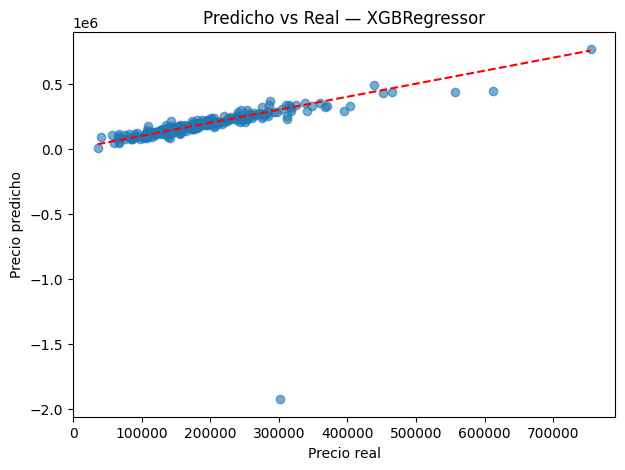

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.scatter(y_valid, results[df_results_sorted.index[0]]["pred"] if isinstance(results[0]["pred"], np.ndarray) else best_row["pred"], alpha=0.6)
plt.xlabel("Precio real"); plt.ylabel("Precio predicho")
plt.title(f"Predicho vs Real — {best_row['model']}")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.show()

## ALTERNATIVO AutoML (PyCaret + TPOT/FLAML/LazyPredict)

In [ ]:
import numpy as np
import pandas as pd

# 1) Base para AutoML
df_auto = df_enhanced.copy() if 'df_enhanced' in globals() else df_imputed.copy()

# 2) Target log
df_auto['SalePrice_log'] = np.log1p(df_auto['SalePrice'])

# 3) Detectar columnas numéricas problemáticas
num_cols = df_auto.select_dtypes(include=[np.number]).columns.tolist()

# Reemplazar inf/-inf por NaN para poder tratarlos
df_auto[num_cols] = df_auto[num_cols].replace([np.inf, -np.inf], np.nan)

# 4) Dropear columnas con demasiados NaN
bad_cols = [c for c in num_cols if df_auto[c].isna().mean() > 0.20]
if bad_cols:
    print(f"🧹 Drop {len(bad_cols)} cols con >20% NaN:", bad_cols[:10], "...")
    df_auto = df_auto.drop(columns=bad_cols)
    # Recalcular lista numérica
    num_cols = df_auto.select_dtypes(include=[np.number]).columns.tolist()

# 5) Imputación simple (median) sobre lo restante
for c in num_cols:
    if df_auto[c].isna().any():
        df_auto[c] = df_auto[c].fillna(df_auto[c].median())

# 6) Capping de outliers extremos
num_cols = [c for c in num_cols if c != 'SalePrice_log']
q_low  = df_auto[num_cols].quantile(0.001)
q_high = df_auto[num_cols].quantile(0.999)
df_auto[num_cols] = df_auto[num_cols].clip(lower=q_low, upper=q_high, axis=1)

# 7) Chequeo final de finitud
_ary = df_auto.select_dtypes(include=[np.number]).to_numpy(dtype=np.float64)
assert np.isfinite(_ary).all(), "Siguen quedando inf/NaN en numéricos"

print("✅ df_auto limpio:", df_auto.shape, "num_cols:", len(num_cols))

from pycaret.regression import (
    setup, compare_models, pull, tune_model,
    blend_models, finalize_model, predict_model
)

exp = setup(
    data=df_auto,
    target='SalePrice_log',
    train_size=0.8,
    fold=5,
    session_id=42,
    normalize=True,
    transformation=False,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    verbose=False
)

top3 = compare_models(sort='RMSE', n_select=3)
results_pc = pull(); display(results_pc.head(10))

if not isinstance(top3, list):
    top3 = [top3]
tuned = [tune_model(m, optimize='RMSE') for m in top3]
blend = blend_models(estimator_list=tuned, optimize='RMSE')
final = finalize_model(blend)

print("✅ Campeón PyCaret:", final)

# Predicciones en hold-out y volver a escala original
holdout = predict_model(final)
holdout['SalePrice_pred'] = np.expm1(holdout['Label'])
display(holdout[['Label','SalePrice_pred']].head())

